# <h1 style="font-size:30px;">Model Interpretability using GradCAM</h1>

Thus far in the course, we have performed image classification using many different models and datasets. We have seen how accurate such models can be and also cases where they fail. But we have not studied the results at a deeper level to understand what it is about a particular image that causes the model to make such predictions. This is referred to as model interpretability and amounts to highlighting features in an input image deemed relevant for the prediction of a learned model.

<img src="https://opencv.org/wp-content/uploads/2022/08/c4-04-gradcam-feature-image.png">

Several approaches have been developed over the last several years to study model interpretability. References to several research papers are provided below; although this is not an exhaustive list, and this remains a very active research area. 
 
| Research Paper | Submission Date(s) |
|:------|:--------|
|<a href="https://arxiv.org/abs/1312.6034"  target="_blank">Saliancy Maps  </a> | (Simonyan, 2013 to 2014)| 
|<a href="https://arxiv.org/abs/1512.04150" target="_blank">Class Activation Mapping (CAM) </a> | (Zhou, 2015)
|<a href="https://arxiv.org/abs/1610.02391" target="_blank">Grad-CAM       </a> | (Selvaraju, 2016 to 2019)|
|<a href="https://arxiv.org/abs/1710.11063" target="_blank">Grad-CAM++     </a> | (Chattopadhya, 2017 to 2018)|
|<a href="https://arxiv.org/abs/2011.08891" target="_blank">HiResCAM       </a> | (Draelos, 2020 to 2021)|

To introduce the topic of model interpretability, we will demonstrate the use of Grad-CAM, based on the original paper (listed as "Grad-CAM" above). More recent work, such as HighResCAM produce more relevant results, but these approaches were inspired by Grad-CAM, and therefore, Grad-CAM represents an ideal starting point for introducing the topic of model interpretability.

Grad-CAM is a method for producing heatmaps applied to an already-trained neural network after training is complete, and the parameters are fixed.


***Notes:***

1. Another recent and relevant paper on this topic, <a href="https://arxiv.org/abs/1810.03292" target="_blank">Sanity Checks for Saliency Maps (Adebayo, 2018 to 2020)</a>, proposes a testing methodology to evaluate the adequacy of model explanation approaches. Several methods have emerged as popular tools to highlight features in an input image deemed relevant for the prediction of a learned model. These approaches are often guided by visual appeal on image data but without a quantifiable method to evaluate the adequacy of the approach. This paper shows that models with randomized weights trained on data with randomized labels will still produce convincing-looking “explanations” for certain techniques, including Guided GradCAM and Guided Backpropagation. This means that these approaches aren’t related to the model’s parameters or the training data. This finding further highlights that this is a very active area of research. 

</br></br>

2. In the HiResCAM paper cited above, the authors state that Grad-CAM sometimes highlights locations the model did not actually use, and they attribute this to the gradient averaging step used by GradCAM. HiResCAM addresses this problem by using an element-wise product between the raw gradients and the feature maps. HiResCAM accomplishes all the same purposes as Grad-CAM, with the benefit that HiResCAM is provably guaranteed to highlight only the regions the model used for any CNN ending in one fully connected layer. 

</br></br>

3. For reference, we are providing the following link from Keras code examples <a href="https://keras.io/examples/vision/grad_cam/" target="_blank">here</a>, which was used as a basis for this notebook.

## Table of Contents

* [1 Model Interpretability](#1-Model-Interpretability)
* [2 Class Activation Mapping (CAM)](#2-Class-Activation-Mapping-(CAM))
* [3 Introduction to GradCAM](#3-Introduction-to-GradCAM)
* [4 Download and Extract Sample Data](#4-Download-and-Extract-Sample-Data)
* [5 Load ResNet50 Pre-Trained Model](#5-Load-ResNet50-Pre-Trained-Model)
* [6 Grad-CAM Building Blocks](#6-Grad-CAM-Building-Blocks)
* [7 Grad-CAM Examples](#7-Grad-CAM-Examples)
* [8 Conclusion](#8-Conclusion)

In [1]:
import numpy as np
import cv2
import os
import requests
import zipfile
import json

import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.cm as cm

## 1 Model Interpretability

In the world of neural networks, model interpretability is a big issue. With millions of trainable parameters, neural networks have long been considered black boxes. They can produce stunning results, and we often accept the output with very little understanding as to why the model makes the predictions that it does. In some cases, models can learn unintended correlations and therefore produce "correct" results that are unrelated to the intended task. 

The following paper cites several cases where models have produced "correct" results based on unintended image features: <a href="https://arxiv.org/pdf/1902.10178.pdf" target="_blank">Lapuschkin et al. 2019 "Unmasking Clever Hans Predictors and Assessing What Machines Really Learn"</a>. In one example, an image classification model learns to classify an image as a “horse” based on the presence of a source tag present in one-fifth of the horse images in the dataset. If this “horse source tag” is placed on an image of a car, then the network classifys the image as a “horse.” So in this case, the model learned the correlation between the source tag and the ground truth label rather than learning features that are unique to horses. It is, therefore, useful to visualize where a neural network is looking because it helps us understand if the neural network is looking at appropriate parts of the image, or if the model is using some other information in the image to obtain the "correct" result. 

In the last decade, much research has been carried out on model interpretability with emphasis on visualizing the data within the model that is used for making predictions. Class Activation Mapping (CAM) is one approach that gained traction and spurred several follow-on methods (GradCAM, GradCAM++ and HiResCAM). The output from such models tell us which portions of an input image are used for prediction. They show what the model focuses on (or "sees") when making predictions for a particular class. It makes the decision-making of neural networks more transparent by providing us with a visual interpretation of the output.

In the following sections, we will first introduce the idea behind CAMs in the context of image classfication, and then we'll cover the GradCAM model, which is a generalization of CAM.

## 2 Class Activation Mapping (CAM)

### 2.1 CAM Architecture

The idea behind CAM is to take advantage of a specific type of convolutional neural network architecture that uses Global Average Pooling (GAP).  The architecture contains a number of convolutional layers for feature extraction, followed by a GAP layer, and then one fully-connected layer that outputs classification scores. 

<img src="https://opencv.org/wp-content/uploads/2022/08/c4-04-CAM-architecture.png" width="900">

### 2.2 Classification Scores

Let's first discuss how we compute the classification scores using this architecture. In the diagram above, the last convolutional layer produces `k` feature maps. Just before the final output layer (softmax in the case of image classification), global average pooling is performed on the convolutional feature maps. Global average pooling turns a feature map into a single number by averaging the numbers in the feature map. After we perform Global Average Pooling, we have `k` numbers which are converted to classification scores using a single fully connected layer. 

If we have k=3 feature maps, we’ll end up with k=3 numbers after global average pooling. We then use those numbers as features for a fully-connected layer that produces the desired output (categorical or otherwise). For example, for a given class, we produce the class score, $y^{c}$, as the weighted sum of the GAP numbers and the weights from the fully connected layer (for a given class) that were learned during training. In the equation below $GAP(A^k)$ represents global average pooling on feature map $A^k$, which is a scalar.

$$ y^{c} = w_1 \cdot GAP(A^1) + w_2 \cdot GAP(A^2) + w_3 \cdot GAP(A^3)$$

Another way to look at this is that the GAP computation summarizes the information from each feature map, and then we learn the weights in the fully connected layer to make predictions. Therefore, the weighted sum of the feature maps for a given class should indicate which regions within the feature maps were most relevant to the prediction.

*Note that in the diagram, we're only showing the connections in the fully connected layer for a single class to avoid clutter in the figure and simplify the indexing. In reality, the output from each node in the GAP layer is connected to each node in the output layer.*

### 2.3 Class Activation Maps (CAM)

Now that we’ve covered the processing to produce the class scores, we'll see that generating the class activation maps follows a very similar computation. We compute the class activation heatmaps as the weighted sum of the activation maps.

$$ CAM^{c} = w_1 \cdot A^1 + w_2 \cdot A^2 + w_3 \cdot A^3$$

This weighted sum is depicted in the graphic below after it was upsampled to match the size of the input image:

<img src="https://opencv.org/wp-content/uploads/2022/08/c4-04-CAM-computation.png" width="900">

**Note**: One caveat regarding the architecture required for CAM is that it requires a GAP layer followed by a single fully connected layer to produced class activation maps. In the next section below, we'll cover **GradCAM** which is a generalization of CAM and does not require a specific type of architecture.

## 3 Introduction to GradCAM

GradCAM, which is short for **Gradient-weighted Class Activation Mapping** was introduced in the paper <a href="https://arxiv.org/abs/1610.02391" target="_blank">Grad-CAM: Gradient-weighted Class Activation Mapping</a> by Selvaraju et al. GradCAM is more versatile than CAM because it can produce visual explanations heatmaps for any arbitrary CNN architecture. The figures below from the research paper are examples of GradCAM output. 

<img src="https://opencv.org/wp-content/uploads/2022/08/c4-04-gradcam-dog-cat.png" width="900">

### 3.1 Grad-CAM Architecture

The difference between CAM and Grad-CAM is in how the feature maps are weighted to compute the final heatmap. In CAM, we weight these feature maps using the weights from the fully-connected layer of the network. In Grad-CAM, feature maps are weighted using **alpha** values that are computed based on gradients. Therefore, Grad-CAM does not require a particular architecture since gradients can be computed through any kind of neural network layer we want. In the figure below we depict a single fully connected layer after the last convoluional layer for sake of example. The following sections describe the processing pipeline depicted in the figure architecture diagram below.

<img src="https://opencv.org/wp-content/uploads/2022/08/c4-04-gradcam-architecture.png"  width="950">

### 3.2 Step 1: Gradient Computation

Each feature map from the last convolutional layer captures varying degrees of high-level information about the input image that is used in the computation of the final score for a given class. Our goal is to study the relationship between the feature maps and the output. For any given class, `c`, a change in the feature map would change the value of the score for that class. Therefore, the authors suggest that the gradient of the class score, $y^{c}$, with respect to the feature maps, $A^k$, should be used as the basis for computing an importance score to highlight regions in the input image that were used to make the prediction.

$$
\begin{align}
\frac{\partial y^{c}}{\partial A^{k}} 
\end{align}
$$

The equation above, $y^{c}$, is a scalar (predicted score prior to the softmax computation) and $A^k$ is a two-dimensional feature map. So the gradient is also a two-dimensional map that has the same spatial dimensions as the feature maps, $A^k$.

### 3.3 Step 2: Compute Alpha Values

In this step, we now perform global average pooling of the gradients over the width and height to obtain alpha values which can be interpreted as importance values. The computation below produces `k` alpha values for each class, where `Z` is the total number of pixels in each feature map.

$$
\begin{align}
\alpha_k^{c} = \frac{1}{Z}\sum_i \sum_j \frac{\partial y^{c}}{\partial A_{ij}^{k}} 
\end{align}
$$

### 3.4 Step 3: Generate Grad-CAM Heatmap

The alpha values computed in the previous step are analogous to the weights in the final layer for the CAM approach, except that the alpha values were generated using gradients. 

Similar to CAM, we can now compute a weighted sum of the activation maps where the weights are the alpha values computed above.


$$ \sum_k \alpha_k^{c} A^k = \alpha_1^c \cdot A^1 + \alpha_2^c \cdot A^2 + \alpha_3^c \cdot A^3$$

Finally, to compute the Grad-CAM heatmap, we pass the above weighted sum through a `ReLU` activation function to zero out any negative gradients.

$$L_{Grad-CAM}^c = ReLU(  \sum_k \alpha_k^{c} A^k  )$$

The computation above will produce a coarse localization map that has the same spatial dimensions as the feature maps, so to generate a final heatmap that can be overlayed on the image, the heatmap is simply upsampled to the same size as the input image and normalized to the range [0., 1.].

## 4 Download and Extract Sample Data

Here we will download and extract a few sample images as well as a JSON file that contains the ImageNet class mappings.

In [2]:
def download_file(url, save_name):
    url = url
    if not os.path.exists(save_name):
        file = requests.get(url)
        open(save_name, 'wb').write(file.content)

In [3]:
def unzip(zip_file=None):
    try:
        with zipfile.ZipFile(zip_file) as z:
            z.extractall("./")
            print("Extracted all")
    except:
        print("Invalid file")

In [4]:
download_file(
    'https://www.dropbox.com/s/eegr2c2qv7eq6i5/gradcam_data.zip?dl=1',
    'gradcam_data.zip'
)
    
unzip(zip_file='gradcam_data.zip')

Extracted all


### 4.1 Build ImageNet Dictionaries

It will be hepful to create dictionary mappings between the ImageNet class labels and the associated class IDs. We have provided the ImageNet class index `json` file for this purpose.

In [5]:
imagenet_class_index = json.load(open(os.path.join('gradcam_data', 'imagenet_class_index.json')))
class_labels = []

# Build list of class names.
for idx in range(len(imagenet_class_index)):
    class_labels.append(imagenet_class_index[str(idx)][1])

# Create Class ID dictionary from list of class names (accepts class ID and returns class name)
class_id_dict = { i : class_labels[i] for i in range(0, len(class_labels) ) }

# Create Class Name dictionary by swapping the key / value enrties (accepts class name and returns class ID).
class_name_dict = dict([(value, key) for key, value in class_id_dict.items()])

## 5 Load ResNet50 Pre-Trained Model

Load the ResNet50 Model and print the summary to confirm the name of the last convolutional layer.

In [6]:
# Load the ResNet50 model with ImageNet weights.
model = tf.keras.applications.ResNet50(weights='imagenet')
model.summary()

2022-08-12 08:59:40.362299: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

## 6 Grad-CAM Building Blocks

### 6.1 Function to Pre-Process Image for Infernece

In the next code cell we have a simple function to read and preprocess an image and return it's NumPy 4D array equivalent.

In [7]:
# Function to read, preprocess, and return an image array.
def process_image(img_path, size=(224, 224)):

    # Read image file from disk.
    rgb_image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

    # Resize image.
    img_array = cv2.resize(rgb_image, size)

    # Add batch dimension.
    img_array = np.expand_dims(img_array, axis=0)

    return rgb_image, img_array

### 6.2 Function to Compute Grad-CAM Heatmap

The function below implements the Grad-CAM processing to produce a Grad-CAM heatmap. The optional input argument `pred_index` allows you to specify which class should be used to produce the heatmap. If not specified, then the heatmap will be generated based on the top scoring predicted class.

In [8]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    
    # Remove the softmax activation from the final output layer. This is necessary because 
    # we need to compute the gradient of the class score (before the softmax activation)
    # with respect to the feature map activations.
    model.layers[-1].activation = None
    
    # Create a model that maps the input image to the activations of the last convolutional 
    # layer as well as the output predictions.
    grad_model = tf.keras.Model(inputs=[model.inputs], 
                                outputs=[model.get_layer(last_conv_layer_name).output, model.output],
                               )
    
    # Define a GradientTape object to monitor the computations for activation maps and the class scores.
    with tf.GradientTape() as tape:
        
        last_conv_layer_output, preds = grad_model(img_array)
        
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
            
        class_channel = preds[:, pred_index]
        
    # Compute the gradient of the output neuron (top predicted or chosen) with  
    # respect to the feature map activations from the last convolutional layer.
    # Each gradient (map) has the same (2D) shape as the activation maps.
    grads = tape.gradient(class_channel, last_conv_layer_output)
    
    # Perform global average pooling on each gradient map. This is a vector where 
    # neach entry is the mean intensity of the corresponding 2D gradient map.
    # These are the alpha values that will be used to weight each activation map.
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # Computed the weighted sum of the activation maps using the pooled gradients.
    heatmap = tf.matmul(last_conv_layer_output[0], pooled_grads[..., tf.newaxis])
    heatmap = tf.squeeze(heatmap)
    
    # Clip heatmap values below zero and normalize the heatmap to the range [0., 1.].
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    
    return heatmap.numpy()

### 6.3 Function to Display Heatmap Overlayed on Image

In [9]:
def display_heatmap(image, heatmap):    
    
    h, w, _ = image.shape
    
    # Resize the heatmap to be the same size as the input image so it can be overlayed on the image.
    heatmap = cv2.resize(heatmap, (w, h))
    
    # Convert the heatmap to RGB and use a "jet" color map so that dark red corresponds to highly 
    # activated regions within the image and blue corresponds to regions with less activation.
    heatmap = np.uint8(255 * heatmap)
    cmap = cm.get_cmap('jet')
    colors = cmap(np.arange(256))[:, :3]
    rgb_heatmap = colors[heatmap]

    # Overlay the heatmap on the original input image.
    final_image = rgb_heatmap*0.6 + image/255.
    
    images = [heatmap, rgb_heatmap, final_image]
    
    plt.figure(figsize=(21, 18))
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.imshow(images[i])
        plt.axis('off')
        plt.tight_layout()
    plt.show()

## 7 Grad-CAM Examples

### 7.1 Load and Prepare Input Image

In [10]:
# Load the dog / cat image from the research paper.
image_path = os.path.join('gradcam_data', 'boxer_tiger_cat.png')

# Prepare the image for inference. 
rgb_image, img_array = process_image(image_path)

### 7.2 Specify Last Convolutional Layer

In [11]:
# Specify the last convolutional layer name (see model summary output above).
last_conv_layer_name = "conv5_block3_out"

### 7.3 Generate Grad-CAM Heatmap [Boxer]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


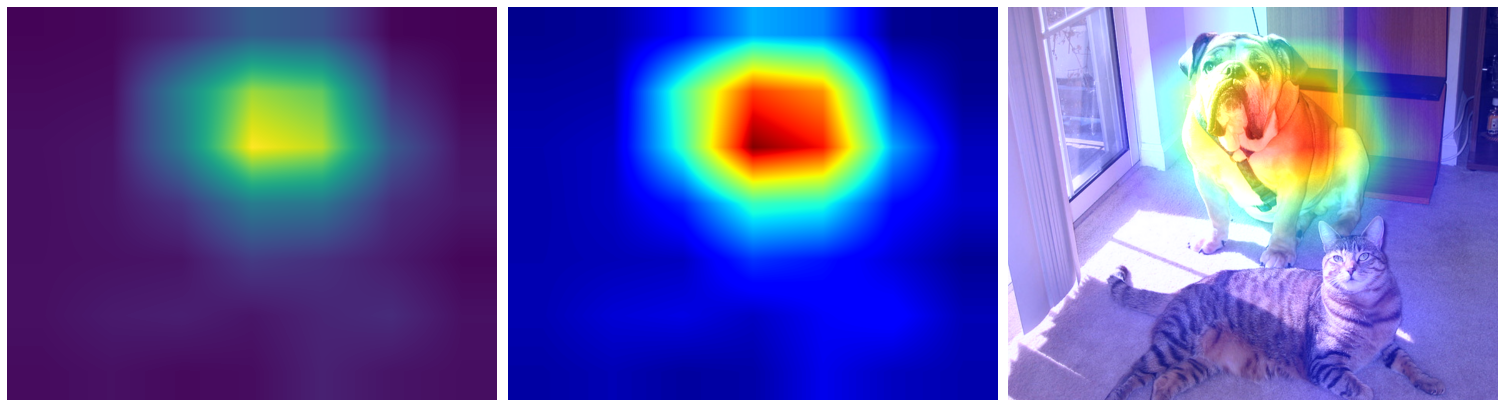

In [12]:
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

display_heatmap(rgb_image, heatmap)

### 7.4 Generate Grad-CAM Heatmap [Tiger Cat]

For reference you can find the list of ImageNet class <a href="https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a" target="_blank">here</a>, or you can open the `json` file that was downloaded above. 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


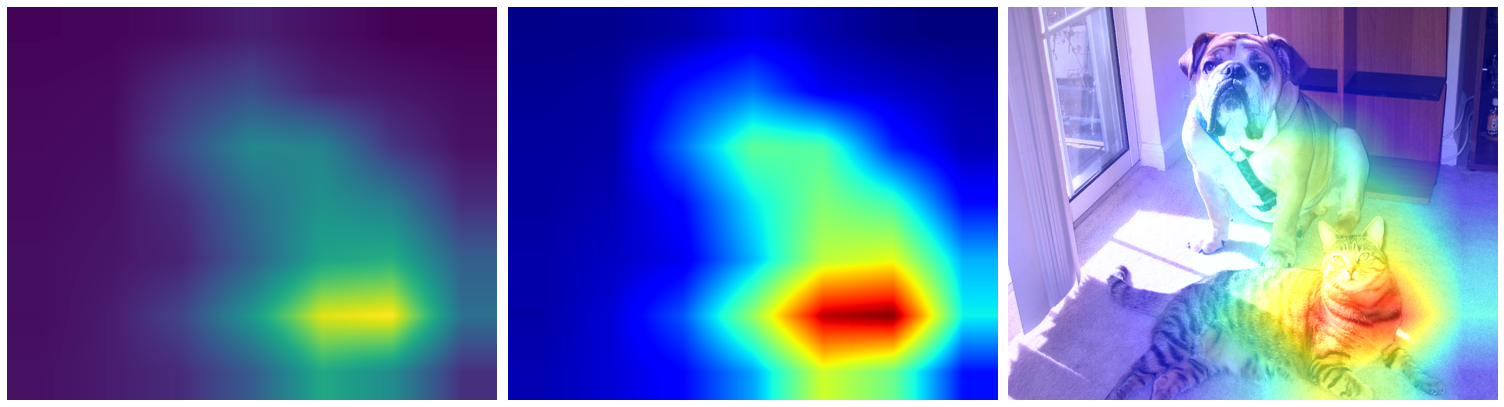

In [13]:
class_index = class_name_dict["tiger_cat"]

heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=class_index)

display_heatmap(rgb_image, heatmap)

### 7.5 Compute Heatmaps for Top-5 Predictions

Top 1 predicted class:   Pr(Class=boxer                [index=   0]) = 40.00
Top 2 predicted class:   Pr(Class=Great_Dane           [index=   1]) = 29.22
Top 3 predicted class:   Pr(Class=tiger_cat            [index=   2]) = 12.80
Top 4 predicted class:   Pr(Class=bull_mastiff         [index=   3]) =  2.30
Top 5 predicted class:   Pr(Class=bluetick             [index=   4]) =  1.72


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


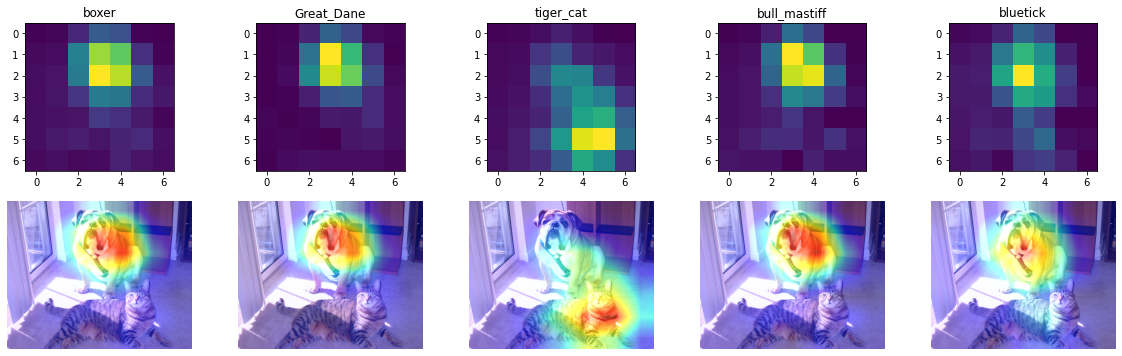

In [14]:
#-------------------------------
# Model Predictions (inference)
#-------------------------------
model = tf.keras.applications.ResNet50(weights='imagenet')

# Perform inference and retrieve the predictions.
preds = model.predict(img_array)

# Decode the predictions.
top_k = 5
processed_preds = tf.keras.applications.resnet50.decode_predictions(preds=preds, top=top_k)
# decode_predictions() returns a sorted list of predictions like this:
#
#   ('n02129604', 'tiger',     0.9805572), 
#   ('n02123159', 'tiger_cat', 0.019321717)


# Display top_k prediction summary data.
for idx in range(top_k):
    print("Top {} predicted class:   Pr(Class={:20} [index={:4}]) = {:5.2f}".format(
        idx + 1, processed_preds[0][idx][1], idx, processed_preds[0][idx][2] * 100))
    
#-------------------------------
# Grad-CAM Heatmap
#-------------------------------  
plt.figure(figsize=(20, 6));
last_conv_layer_name = "conv5_block3_out"

# Display raw Grad-CAM heatmap and resized heatmap overlayed on the original image.
for idx in range(top_k):
    
    class_label = processed_preds[0][idx][1]
    class_index = class_name_dict[class_label]
    
    heatmap = make_gradcam_heatmap(img_array, 
                                   model, 
                                   last_conv_layer_name, 
                                   pred_index=class_index)

    plt.subplot(2, top_k, idx + 1)
    plt.title(class_label)
    plt.imshow(heatmap)
    
    # Resize the heatmap to be the same size as the input image so it can be overlayed on the input image.
    h, w, _ = rgb_image.shape
    heatmap = cv2.resize(heatmap, (w, h))
    
    # Convert the heatmap to RGB and use a "jet" color map so that dark red corresponds to highly 
    # activated regions within the image and blue corresponds to regions with less activation.
    heatmap = np.uint8(255 * heatmap)
    cmap = cm.get_cmap('jet')
    colors = cmap(np.arange(256))[:, :3]
    rgb_heatmap = colors[heatmap]

    # Overlay the heatmap on the original image.
    final_image = rgb_heatmap*0.6 + rgb_image/255.
    
    plt.subplot(2, top_k, top_k + idx + 1)
    plt.imshow(final_image)
    plt.axis("Off");

### 7.6 Compute Grad-CAM Heatmap for Intermediate Convolutional Layer 
As an experiment, let's see what happens when we use an intermeddiate convolutoinal layer as the basis for the Grad-CAM heatmap.

In [15]:
# Specifiy an earlier (intermediate) layer in the network.
last_conv_layer_name = "conv4_block1_out"

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


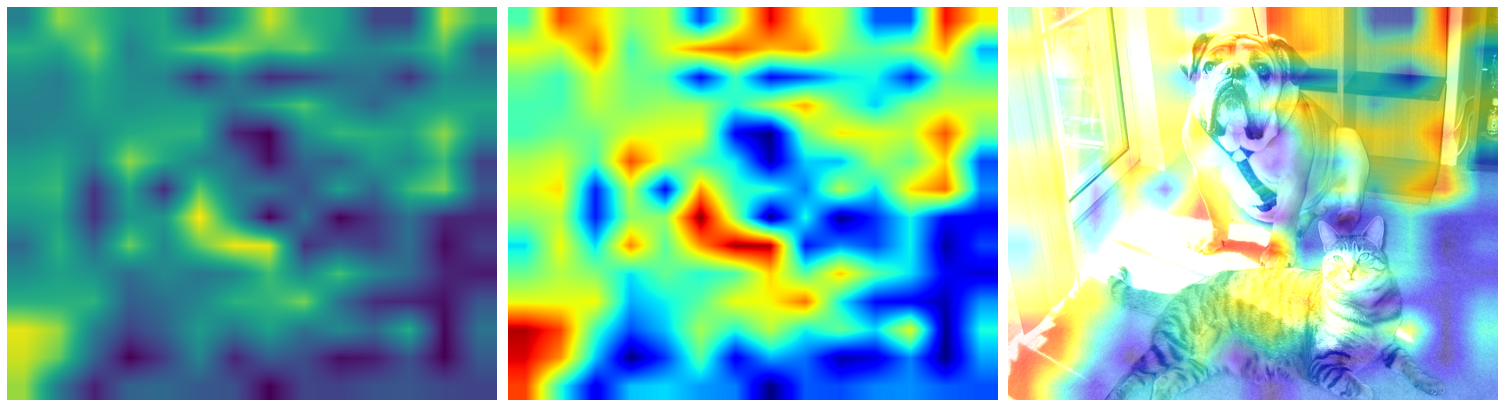

In [16]:
class_index = class_name_dict["boxer"]

heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=class_index)

display_heatmap(rgb_image, heatmap)

As you can see in the images above, the information from earlier convolutional layers in the network seem to contain informaion related to lower level patterns rather than higher-level contextual information. If you try layers closer to the final layer (like `conv5_block1_out` or `conv5_block2_out`), you'll see the heatmaps produced are more closely tied to objects of each class.

### 7.7 Add Convenience Function to Handle Top-K Predictions

Let's now create a convenience function that provides the flexibility to display the top-k scores from the model and create a heatmap for the top scoring class. The function also allows you to specify a specific class to use for heat map creation rather than the top scoring class. This is useful for seeing what portions of the image were used for class predictions other than the highest scoring class. 

In [17]:
def gradcam_topk_summary(image_path, model, top_k=1, pred_index=None):
    
    # Preprocess image.
    rgb_image, image_array = process_image(image_path)
   
    # Perform inference.
    preds = model.predict(image_array)
    
    # Can use either method below.
    # processed_preds = tf.keras.applications.resnet50.decode_predictions(preds=preds, top=top_k)
    processed_preds = tf.keras.applications.imagenet_utils.decode_predictions(preds=preds, top=top_k)
    
    # Display top_k prediction summary data.
    for idx in range(top_k):
        print("Top {} predicted class:   Pr(Class={:20} [index={:4}]) = {:5.2f}".format(
            idx + 1, processed_preds[0][idx][1], idx, processed_preds[0][idx][2] * 100))
    
    # The name of the last convolutional layer.
    last_conv_layer_name = "conv5_block3_out"
    
    # Obtain the heatmap for either the top scoring class or the class indicated by `pred_index`.
    heatmap = make_gradcam_heatmap(image_array, model, last_conv_layer_name, pred_index=pred_index)
    
    # Overlay the heatmap on the input image.
    display_heatmap(rgb_image, heatmap)

Top 1 predicted class:   Pr(Class=tiger                [index=   0]) = 98.06
Top 2 predicted class:   Pr(Class=tiger_cat            [index=   1]) =  1.93
Top 3 predicted class:   Pr(Class=common_iguana        [index=   2]) =  0.01
Top 4 predicted class:   Pr(Class=zebra                [index=   3]) =  0.00
Top 5 predicted class:   Pr(Class=pug                  [index=   4]) =  0.00


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


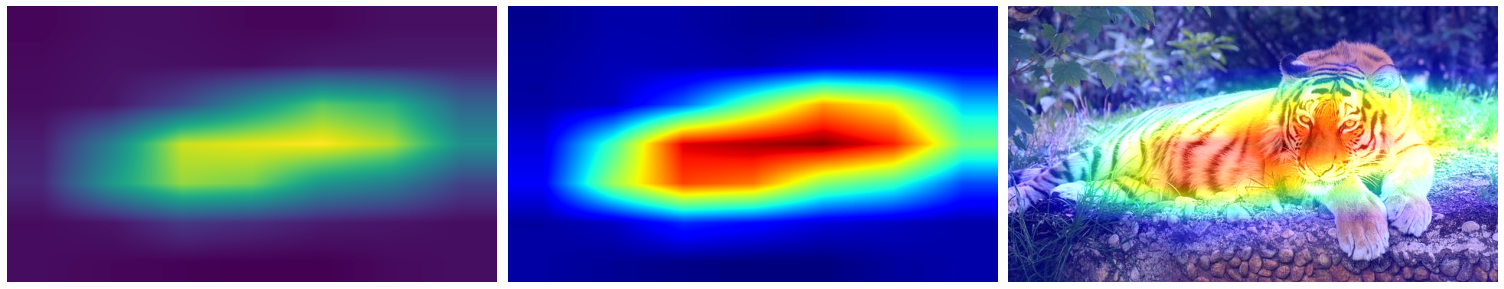

In [18]:
image_path = os.path.join('gradcam_data', 'tiger.jpg')

gradcam_topk_summary(image_path, model, top_k=5)

In the results shown above, we can see how the model focuses on almost the entire body of the tiger. But this may not always be the case. Often times the model may focus on some unique portion of the class object. 

Let's look at another case.

Top 1 predicted class:   Pr(Class=leatherback_turtle   [index=   0]) = 64.61
Top 2 predicted class:   Pr(Class=loggerhead           [index=   1]) = 14.40
Top 3 predicted class:   Pr(Class=terrapin             [index=   2]) = 13.44
Top 4 predicted class:   Pr(Class=coral_reef           [index=   3]) =  1.90
Top 5 predicted class:   Pr(Class=snail                [index=   4]) =  0.76


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


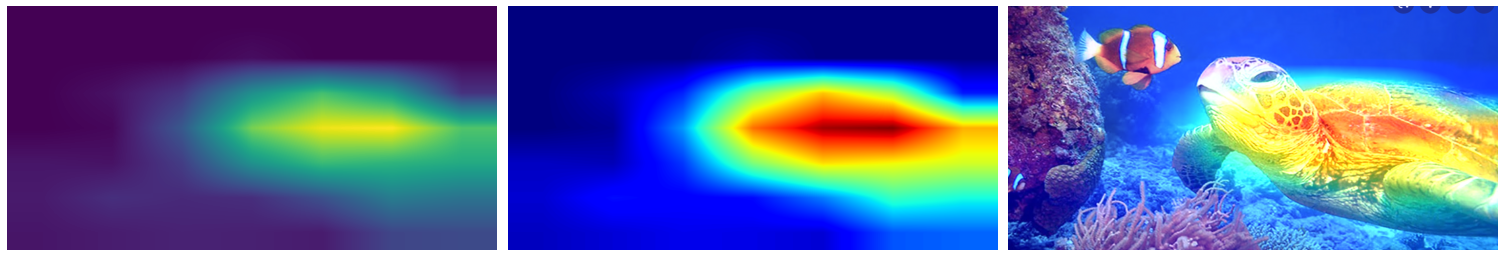

In [19]:
image_path = os.path.join('gradcam_data', 'turtle.png')

gradcam_topk_summary(image_path, model, top_k=5)

Here we can see that the top scoring class is the turtle. In fact, the top three scores are different types of turtles, so the model is actually 92% confident this is a turtle. Notice that the 4th highest prediction is `coral_reef`, which makes sense. Interestingly, though, the clownfish shown in the image is not listed in the top five predictions. In the next code cell below, we process the same image, but this time we specify that we want to generate a heatmap for the class `coral_reef`.

Top 1 predicted class:   Pr(Class=leatherback_turtle   [index=   0]) = 64.61
Top 2 predicted class:   Pr(Class=loggerhead           [index=   1]) = 14.40
Top 3 predicted class:   Pr(Class=terrapin             [index=   2]) = 13.44
Top 4 predicted class:   Pr(Class=coral_reef           [index=   3]) =  1.90
Top 5 predicted class:   Pr(Class=snail                [index=   4]) =  0.76


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


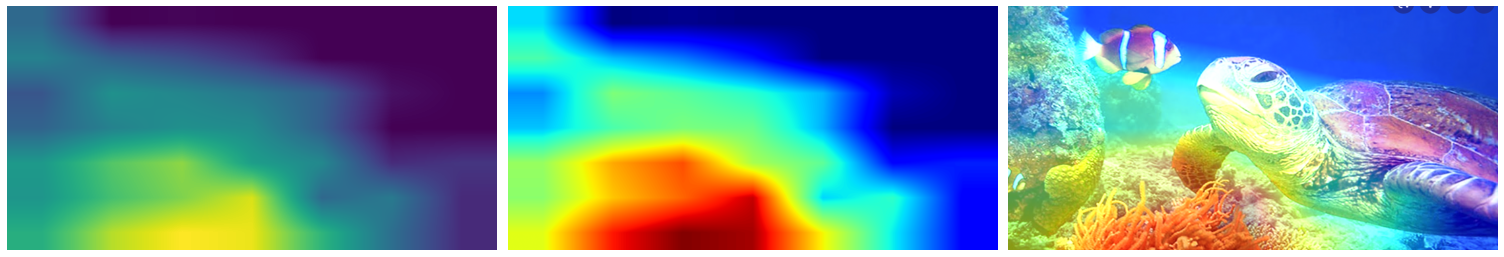

In [20]:
image_path = os.path.join('gradcam_data', 'turtle.png')

class_index = class_name_dict["coral_reef"]

gradcam_topk_summary(image_path, model, top_k=5, pred_index=class_index)

And as you can see, the heatmap produced seems to make sense since it is now focusing on the lower left portion of the image. In the final example, we have a large image of a clownfish (although partially obscured), and the model is over 99% confident in this prediction (`anemone_fish` is the scientific name for a clownfish).

Top 1 predicted class:   Pr(Class=anemone_fish         [index=   0]) = 99.53
Top 2 predicted class:   Pr(Class=sea_anemone          [index=   1]) =  0.46
Top 3 predicted class:   Pr(Class=cup                  [index=   2]) =  0.00
Top 4 predicted class:   Pr(Class=coral_reef           [index=   3]) =  0.00
Top 5 predicted class:   Pr(Class=spotlight            [index=   4]) =  0.00


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


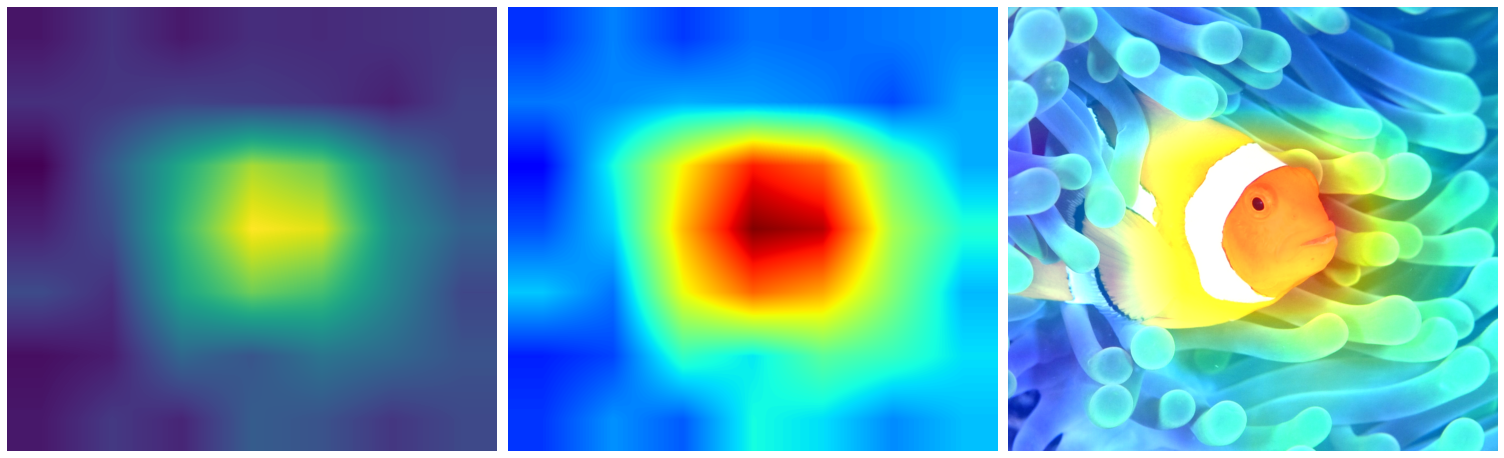

In [21]:
image_path = os.path.join('gradcam_data', 'clownfish.png')

gradcam_topk_summary(image_path, model, top_k=5)

## 8 Conclusion

In this notebook, we introduced the general topic of model interpretability and provided references to several approaches that have been developed over the past several years aimed to provide visual explanations for why CNNs make the predictions that they do. We covered the basic idea behind Class Activation Mapping and showed how Grad-CAM is a generalization of CAM that uses gradients to produce the final result. The full implementation of GradCAM was demonstrated using a pre-trained ResNet50 model.

As previously noted, there are some cases where Grad-CAM is known to highlight regions of an image that were not used for prediction. This finding gave rise to another approach called HiResCAM, which uses a slightly different approach for computing the gradients. HiResCam eliminates the global pooling operation and instead performs an element-wise product between the raw gradients and the feature maps. As an optional exercise, you might try to implement this by modifying the `make_gradcam_heatmap()` function.